# Logistics Optimization

In [1]:
%reload_ext autoreload
%autoreload 2
%reload_ext blackcellmagic
%matplotlib inline

In [2]:
import collections
import json
import math 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

from relearn.env import SimpleLogistics, Warehouse

# Logistics Provider Environment

In this example, we simulate the item delivery of a logistics provider.
We define the problem as **Dispatch items from arbitrary sellers to a logistics provider's distribution center (warehouse) where the logistics provider delivers the items to their destinations**.

To make our problem simpler, we set following assumptions:
- The distribution center operates independently so that we can define the single warehouse in our simulation.
- Items are dispatched and stored into the warehouse every day with a fixed (transportation) cost.
- Each item has one of two types of delivery: 2-day and 7-day delivery.
- There is no penalty for the dispatch failure caused by full-inventory, but there is a penalty for the late delivery.
- Items of the same destination are grouped and shipped together.

> TODO: Currently, this environment doesn't consider the route-optimization.

Here are our environment parameters:

In [3]:
NUM_EPISODES = 100  # days

# Average number of items to dispatch per episode
AVG_DEMAND = 20

# Number of item delivery destinations
NUM_DESTINATIONS = 10

# Distribution center capacity
WAREHOUSE_CAPACITY = 100

# Max items that can be delivered to the same location at a time
DELIVERY_CAPACITY = 5 

SEED = 1234

In [4]:
env = SimpleLogistics(
    T=NUM_EPISODES,
    capacity=WAREHOUSE_CAPACITY,
    delivery_capacity=DELIVERY_CAPACITY,
    num_destinations=NUM_DESTINATIONS,
    demand_fn=AVG_DEMAND,
    seed=SEED,
)
env.render('df').head(5)

/home/jumin/miniconda3/envs/relearn/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


,t,dest,due,price,penalty,dest_cost,dest_cap
0,0.0,7.0,2.0,0.5,0.25,0.801872,4.0
1,0.0,0.0,2.0,0.5,0.25,0.191519,1.0
2,0.0,9.0,2.0,0.5,0.25,0.875933,2.0
3,0.0,1.0,2.0,0.5,0.25,0.622109,3.0
4,0.0,5.0,2.0,0.5,0.25,0.272593,4.0


Text(0, 0.5, 'Demand')

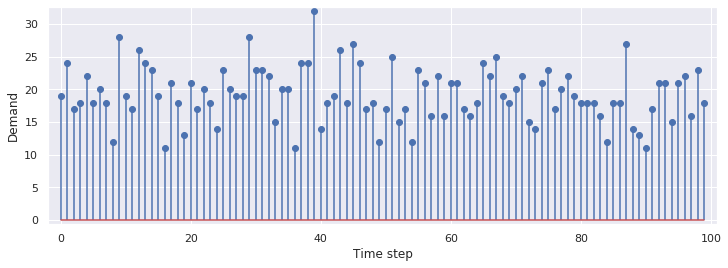

In [5]:
# Visualize demand functions
env.reset(SEED)
plt.figure(figsize=(12,4))
plt.margins(0.02)
plt.stem([len(env.demand()) for _ in range(NUM_EPISODES)], use_line_collection=True)
plt.xlabel("Time step")
plt.ylabel("Demand")

In [6]:
# Delivery costs to each destination area
env.warehouse.delivery_costs

array([0.19151945, 0.62210877, 0.43772774, 0.78535858, 0.77997581,
       0.27259261, 0.27646426, 0.80187218, 0.95813935, 0.87593263])

In [7]:
# Sample action
env.action_space.sample()

array([69,  6, 27, 99, 81, 69, 48, 18, 22,  3,  8, 41, 57, 19, 59, 75,  0,
       51, 70, 63, 81, 84, 94, 61, 41, 20, 21, 51, 34, 60, 59, 76,  9, 57,
        1, 68, 26, 79, 86, 64, 23, 71, 41, 19, 37, 37, 81, 99, 93, 55, 57,
       55, 73,  5, 19, 72, 19, 29, 80, 56, 91, 94, 66, 93, 45, 32, 68, 51,
       53, 40, 57, 49, 44, -1, 78, 82, 14, 85, 84,  2,  2, 85, 29, 33, 59,
       26, 80,  3, 88, 98, 30, 25, 53, 12, 19, 19, 28,  2, 78, 82])

Text(0, 0.5, 'Profit')

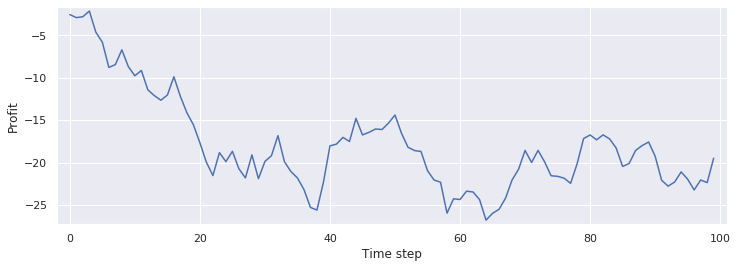

In [8]:
# Random action
env.reset(SEED)
done = False
rewards = []
while not done:
    _, reward, done, info = env.step(env.action_space.sample())
    rewards.append(reward)

plt.figure(figsize=(12,4))
plt.margins(0.02)
plt.plot(rewards)
plt.xlabel("Time step")
plt.ylabel("Profit")

Text(0, 0.5, 'Profit')

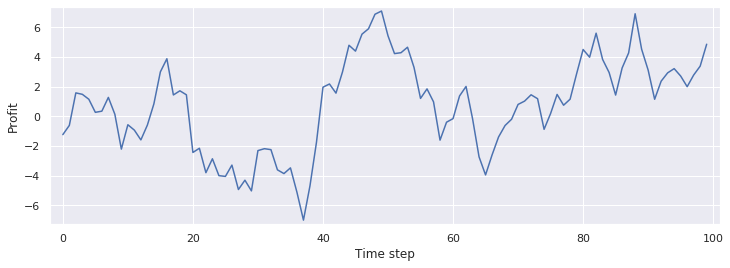

In [9]:
# First come first serve
env.reset(SEED)
done = False
rewards = []
while not done:
    delivery = list(range(len(env.warehouse.inventory)))
    _, reward, done, info = env.step(delivery)
    rewards.append(reward)
#     print(info['num_items_failed_to_deliver'])

plt.figure(figsize=(12,4))
plt.margins(0.02)
plt.plot(rewards)
plt.xlabel("Time step")
plt.ylabel("Profit")

In [ ]:
# TODO plot demands, delivery, penalty, etc. together


# Simple Policy

In [10]:
class WaitAndDeliverPolicy:
    def __init__(
        self,
        due,
        capacity,
        delivery_capacity,
    ):
        """Wait to collect as many items as possible before delivery.
        Deliver when there are due items or reached to delivery_capacity_limit
        or capacity_limit.
        """
        self.due = due
        self.capacity = capacity
        self.delivery_capacity = delivery_capacity

    def action(self, state_df):
        """Check inventory, select items to deliver ():
        """
        full_capacity = len(state_df)
        
        # remove empty
        df = pd.DataFrame(state_df.loc[state_df['price'] > 0.0])
        df['due-t'] = df['due'] - df['t']
        
        if len(df) > self.capacity:
            pass  # Try to deliver all 
        else:
            # deliver the items close to the due date and other items that have the same destinations.
            due_items = df.loc[df['due-t'] < self.due]
            areas = set(due_items['dest'].unique())
            
            # also, include areas where the delivery capacity is full
            dest_cnt = df.groupby('dest').count()['t']
            areas.update(dest_cnt.loc[dest_cnt > self.delivery_capacity].index)
            
            # select the items for those areas
            df = df.loc[df['dest'].isin(areas)]
        
        return np.array(df.sort_values('due-t').index)


In [11]:
wd_policy = WaitAndDeliverPolicy(
    due=1.0,
    capacity=int(WAREHOUSE_CAPACITY * 0.8),
    delivery_capacity=int(DELIVERY_CAPACITY * 0.8),
)

Text(0, 0.5, 'Profit')

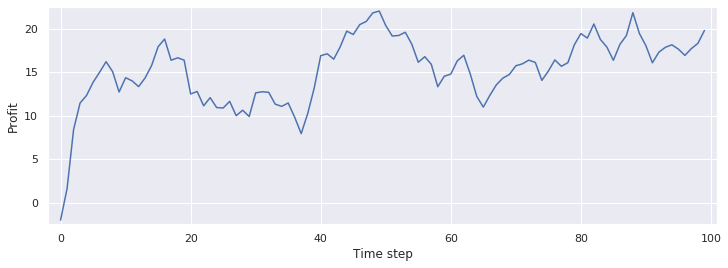

In [12]:
env.reset(SEED)
done = False
rewards = []
while not done:
    action = wd_policy.action(env.render('df'))
    _, reward, done, info = env.step(action)
    rewards.append(reward)
#     print(info['num_items_failed_to_deliver'])

plt.figure(figsize=(12,4))
plt.margins(0.02)
plt.plot(rewards)
plt.xlabel("Time step")
plt.ylabel("Profit")

# Optimizing the Policy Using Reinforcement Learning / RLlib

In [14]:
import numpy as np
import gym
from gym.spaces import Box

import ray
from ray import tune
from ray.rllib.utils import try_import_tf
    
import ray.rllib.agents.ppo as ppo
from ray.tune.logger import pretty_print

tf = try_import_tf()

# gym environment adapter for ray
class RayEnv(gym.Env):
    def __init__(self, config):
        self.env = config["env"]
        self.action_space = self.env.action_space
        self.observation_space = self.env.observation_space

    def reset(self):
        return self.env.reset()

    def step(self, action):
        return self.env.step(action)

ray.shutdown()
ray.init()

config = {}
config["env_config"] = {"env": env}

trainer = ppo.PPOTrainer(config=config, env=RayEnv)
for i in range(2):
    result = trainer.train()
    print("result: {}".format(result))

# def train_ddpg():
#     config = ddpg.DEFAULT_CONFIG.copy()
#     config["log_level"] = "WARN"
#     config["actor_hiddens"] = [512, 512] 
#     config["critic_hiddens"] = [512, 512]
#     config["gamma"] = 0.95
#     config["timesteps_per_iteration"] = 1000
#     config["target_network_update_freq"] = 5
#     config["buffer_size"] = 10000
#     config["env_config"] = {"env": env}
# #     config["num_gpus"] = 0
# #     config["num_workers"] = 1
# #     config["eager"] = False
    
#     trainer = ddpg.DDPGTrainer(config=config, env=RayEnv)
    

2020-03-16 16:50:07,468	WARNING services.py:586 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-03-16 16:50:07,470	INFO resource_spec.py:212 -- Starting Ray with 3.96 GiB memory available for workers and up to 1.98 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-03-16 16:50:07,863	INFO services.py:1078 -- View the Ray dashboard at localhost:8265
/home/jumin/miniconda3/envs/relearn/lib/python3.7/site-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  obj = yaml.load(type_)
2020-03-16 16:50:12,218	WARNING util.py:37 -- Install gputil for GPU system monitoring.


(pid=7943) /home/jumin/miniconda3/envs/relearn/lib/python3.7/site-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
(pid=7943)   obj = yaml.load(type_)
(pid=7933) /home/jumin/miniconda3/envs/relearn/lib/python3.7/site-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
(pid=7933)   obj = yaml.load(type_)


RayTaskError(RayOutOfMemoryError): [36mray::RolloutWorker[39m (pid=7943, ip=192.168.99.193)
  File "python/ray/_raylet.pyx", line 438, in ray._raylet.execute_task
  File "/home/jumin/miniconda3/envs/relearn/lib/python3.7/site-packages/ray/memory_monitor.py", line 122, in raise_if_low_memory
    self.error_threshold))
ray.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node jumin-surface is used (14.79 / 15.56 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
1490	0.87GiB	/usr/bin/gnome-shell
7509	0.62GiB	/home/jumin/miniconda3/envs/relearn/bin/python -m ipykernel_launcher -f /home/jumin/.local/share/jup
3282	0.4GiB	/opt/google/chrome/chrome --type=renderer --disable-webrtc-apm-in-audio-service --field-trial-handle
7933	0.4GiB	ray::RolloutWorker
7943	0.4GiB	ray::RolloutWorker
2612	0.33GiB	/opt/google/chrome/chrome
3052	0.32GiB	/usr/lib/firefox/firefox -new-window
2710	0.29GiB	/opt/google/chrome/chrome --type=renderer --disable-webrtc-apm-in-audio-service --field-trial-handle
2213	0.28GiB	/usr/bin/gnome-shell
3501	0.28GiB	/usr/lib/firefox/firefox -contentproc -childID 5 -isForBrowser -prefsLen 7683 -prefMapSize 211604 -p

In addition, up to 3.59 GiB of shared memory is currently being used by the Ray object store. You can set the object store size with the `object_store_memory` parameter when starting Ray, and the max Redis size with `redis_max_memory`. Note that Ray assumes all system memory is available for use by workers. If your system has other applications running, you should manually set these memory limits to a lower value.

In [ ]:
env.action_space

In [ ]:
env.observation_space

# Analysis and Debugging of the Policy Produced by RLlib

In [ ]:
import json

def load_policy():
    log_dir = ".../ray_results/DDPG_SimpleSupplyChain_2020-01-23_20-51-479cn5z0i0" # this path needs to be set manually
    checkpoint_id = "200"
    with open(f"{log_dir}/params.json", "r") as read_file:
        config = json.load(read_file)
    trainer = ddpg.DDPGTrainer(config=config, env=SimpleSupplyChain)
    trainer.restore(f"{log_dir}/checkpoint_{checkpoint_id}/checkpoint-{checkpoint_id}")
    return trainer.get_policy()

policy = load_policy()

# tracing the policy
env = SupplyChainEnvironment()
state = env.initial_state()
transitions_rl = []
for t in range(env.T):
    action = policy.compute_single_action( state.to_array() , state=[] ) 
    action_obj = Action(env.warehouse_num)
    action_obj.production_level = action[0][0]
    action_obj.shippings_to_warehouses = action[0][1:]
    state, reward, _ = env.step(state, action_obj)
    transitions_rl.append([state, action_obj, reward])

In [ ]:
# tracing the policy
visualize_transitions(np.array(transitions_rl))

In [ ]:
# Using Ray's tune. 
import ray
from ray import tune

ray.init()
tune.run(
    "PPO",
    stop={"episode_reward_mean": 200},
    config={
        "env": "CartPole-v0",
        "num_gpus": 0,
        "num_workers": 1,
        "lr": tune.grid_search([0.01, 0.001, 0.0001]),
        "eager": False,
    },
)
